In [25]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm 
import time

import shap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torchinfo

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve, brier_score_loss, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

import pickle

from scipy.stats import chi2
from pycaleva import CalibrationEvaluator
from utils import augmentation as aug

In [2]:
def tnr_score(y_test, y_pred):
    y_t = np.array(y_test)
    y_p = np.array(y_pred)
    tn = np.sum((1-y_t)*(1-y_p))
    fp = np.sum(y_p*(1-y_t))
    if (tn + fp) == 0:
        return 0
    else:
        return tn / (tn + fp)

In [3]:
# Fonction d'affichage de la matrice de confusion 
def cm_analysis(y_true, y_pred, labels, classes, ymap=None, figsize=(7,7)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1.2)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues", vmin=0, vmax=100)
    # plt.savefig(filename,  bbox_inches='tight')

In [4]:
# Création d'un dataset en concaténant les séries temporelles des différentes variables + les variables statiques
def prepareData(dataGroup, id_list, window_time):
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
    elif dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    else:
        dataPath = "../dataRea/"

    finalDataPath = dataPath + "finalData/"

    data = []

    for encounterId in tqdm(id_list, total=len(id_list)):
        
        df_mask = pd.read_parquet(finalDataPath + encounterId + "/mask.parquet")
        df_dynamic = pd.read_parquet(finalDataPath + encounterId + "/dynamic.parquet")
        df_static = pd.read_parquet(finalDataPath + encounterId + "/static.parquet")

        # 0 --> HR
        # 1 --> SpO2
        # 2 --> PAD
        # 3 --> PAM
        # 4 --> PAS
        # 5 --> RR
        # 6 --> Temperature
        # 7 --> Diuresis
        # 8 --> SpO2/FiO2
        # 9 --> FiO2
        # 10 --> Compliance 
        # 11 --> Dialyse
        # 12 --> ECMO flow
        
        idx_variables_kept = [0,1,2,3,4,5,6,7,9,10]
    
        # Ajout des variables dynamiques
        data_patient = df_dynamic.iloc[:(window_time*24), idx_variables_kept].to_numpy()
    
        # Ajout des variables statiques
        for value in df_static.to_numpy()[0]:
            new_column = np.ones(shape=(window_time*24,1)) * value
            data_patient = np.append(data_patient, new_column, axis=1)
        
        # Ajout de l'IGS II
        # if dataGroup == "dataMimic":
        #     sapsii = patients_df.loc[patients_df["stay_id"]==int(encounterId), "saps_max"].iloc[0]
        #     logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
        #     igs_pred = np.exp(logit)/(1+np.exp(logit))
        # else:
        #     igs_df = pd.read_parquet(finalDataPath + encounterId + "/IGS.parquet")
        #     if igs_df.size > 0:
        #         sapsii = float(igs_df["igsTotal"].iloc[0])
        #         logit = -7.7631 + 0.0737*sapsii + 0.9971 * np.log(sapsii+1)
        #         igs_pred = np.exp(logit)/(1+np.exp(logit))
        #     else:
        #         igs_pred = 0.5
                
        # new_column = np.ones(shape=(window_time*24,1)) * igs_pred
        # data_patient = np.append(data_patient, new_column, axis=1)
        
        data.append(data_patient)
    
    return np.array(data)

# Retourne la liste des encounterId des patients utilisable d'une base de données (utilisable si durée minimale d'hospitalisation est assez grande et si la proportion de valeurs manquantes est suffisamment faible)
def prepareDeathList(dataGroup, window_time):
    target = []
    id_list = []
    
    if dataGroup == "dataMimic":
        dataPath = "../Mimic/dataMimic/"
        
        patients_df = pd.read_csv(dataPath + "ventiles.csv")
        # df_ventilation_start = pd.read_csv(dataPath + "ventiles1.csv")

        nb_patients = len(patients_df)
    
        for index, row in tqdm(patients_df.iterrows(), total=nb_patients):
            stay_id = str(row["stay_id"])

            df_mask = pd.read_parquet(dataPath + "finalData/" + stay_id + "/mask.parquet")
            total_true_values = df_mask.values.sum()
            total_values = df_mask.values.size
            percentageMissingValues = (total_values-total_true_values)/total_values * 100

            if percentageMissingValues < 40:
                id_list.append(stay_id)
                
                label_death = int(row["label"])
                if label_death:
                    target.append(1)
                else:
                    target.append(0)
            
        
        return target, id_list
    
    if dataGroup == "dataECMO":
        dataPath = "../dataECMO/"
    elif dataGroup == "dataRangueil":
        dataPath = "../dataRea/"

    
    patients_df = pd.read_parquet(dataPath + "patients.parquet")

    df_death = pd.read_csv(dataPath + "delais_deces.csv")
    
    nb_patients = len(patients_df)

    for _, row in tqdm(patients_df.iterrows(), total=nb_patients):
        encounterId = str(row["encounterId"])
        
        df_mask = pd.read_parquet(dataPath + "finalData/" + encounterId + "/mask.parquet")
        total_true_values = df_mask.values.sum()
        total_values = df_mask.values.size
        percentageMissingValues = (total_values-total_true_values)/total_values * 100
        
        withdrawal_date = pd.Timestamp(row["withdrawal_date"])
        installation_date = pd.Timestamp(row["installation_date"])
        total_time_hour = (withdrawal_date - installation_date).total_seconds() / 3600 + 4

        if total_time_hour >= window_time * 24 and percentageMissingValues < 40:
            id_list.append(encounterId)
            
            delai_sortie_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_sortie_deces"].to_numpy()[0]
            delai_installation_deces = df_death.loc[df_death["encounterId"] == int(encounterId), "delai_installation_deces"].to_numpy()[0]
            if delai_sortie_deces <= 1: #and delai_installation_deces <= 35:
                target.append(1)
            else:
                target.append(0)
    
    return target, id_list

In [5]:
target_ECMO, id_list_ECMO = prepareDeathList("dataECMO", window_time=5)
data_ECMO = prepareData("dataECMO", id_list_ECMO, window_time=5)

print(f"ECMO dataset size: {len(target_ECMO)} , num_deceased: {np.sum(target_ECMO)}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 285.54it/s]

ECMO dataset size: 153 , num_deceased: 55


In [9]:
# target_Mimic, id_list_Mimic = prepareDeathList("dataMimic", window_time=5)
# data_Mimic = prepareData("dataMimic", id_list_Mimic, window_time=5)

# print(f"Mimic dataset size: {len(target_Mimic)} , num_deceased: {np.sum(target_Mimic)}")

In [10]:
# target_Rangueil, id_list_Rangueil =  prepareDeathList("dataRangueil", window_time=5)
# data_Rangueil = prepareData("dataRangueil", id_list_Rangueil, window_time=5)

# print(f"Rea dataset size: {len(target_Rangueil)} , num_deceased: {np.sum(target_Rangueil)}")

In [11]:
# target_MR = target_Mimic + target_Rangueil
# id_list = id_list_Mimic + id_list_Rangueil

# data_MR = np.concatenate((data_Mimic,data_Rangueil),axis=0)

# print(f"dataset size mimic+rea: {len(target_MR)} , num_deceased: {np.sum(target_MR)}")

In [6]:
# Création des différents modèles

class CNN_1D_0(nn.Module):
    def __init__(self, num_features, num_static_features):
        super(CNN_1D_0, self).__init__()

        self.num_features = num_features
        self.num_static_features = num_static_features

        self.conv1 = nn.Conv1d(in_channels=num_features-num_static_features, out_channels=8, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=1)
        self.fc1 = nn.Linear(480 , 4)
        self.fc2 = nn.Linear(4+num_static_features, 1)

        self.dropout1 = nn.Dropout(p=0.5)

    def forward(self, x):
        cnn_input = x[:, :-self.num_static_features, :]
        static_input = x[:, -self.num_static_features:, 0]

        out = self.pool(nn.functional.relu(self.conv1(cnn_input)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = torch.cat((out, static_input), dim=1)
        # out = self.dropout1(out)
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))
        return out

class CNN_1D_1(nn.Module):
    def __init__(self, num_features):
        super(CNN_1D_1, self).__init__()
        
        self.num_features = num_features

        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1)
        self.fc1 = nn.Linear(1920 , 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):

        out = self.pool(nn.functional.relu(self.conv1(x)))
        out = self.pool(nn.functional.relu(self.conv2(out)))
        out = torch.flatten(out, 1)
        out = nn.functional.relu(self.fc1(out))
        out = self.fc2(out)
        # out = torch.sigmoid(self.fc2(out))
        return out

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(1, 3), padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(1, 3), padding=1)

        self.fc1 = nn.Linear(2976, 4)
        self.fc2 = nn.Linear(4, 1)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.75)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        # x = self.pool(nn.functional.relu(self.conv3(x)))
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout2(x)
        # x = nn.functional.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_static_features):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_static_features = num_static_features
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size + num_static_features, 20)
        # self.fc2 = nn.Linear(20, output_size)
        self.fc2 = nn.Linear(hidden_size + num_static_features, 1)
    
    def forward(self, x):
        lstm_input = x[:, :, :-self.num_static_features]
        static_input = x[:, 0, -self.num_static_features:]

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(lstm_input, (h0, c0))
        out = out[:, -1, :]  # Take the output of the last time step

        out = torch.cat((out, static_input), dim=1)
        # out = torch.relu(self.fc1(out))

        # out = nn.functional.sigmoid(self.fc2(out))
        out = self.fc2(out)
        return out

class LSTMModel2(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static):
        
        super(LSTMModel2, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_features_dynamic = num_features_dynamic
        self.num_features_static = num_features_static
        
        # Create a list of LSTM layers, one for each feature
        self.lstms = nn.ModuleList([nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True) for _ in range(num_features_dynamic)])
        
        # Linear layer for binary classification
        self.fc = nn.Linear(2*hidden_size*num_features_dynamic + num_features_static, output_size)
        
    def forward(self, x):
        
        lstm_outputs = []

        for i in range(self.num_features_dynamic):
            feature_input = x[:, :, i].unsqueeze(2)  # Shape: (batch_size, seq_length, 1)
            h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
            lstm_out, _ = self.lstms[i](feature_input, (h0, c0))
            lstm_out = lstm_out[:, -1, :]  # Get the last time step output: Shape: (batch_size, hidden_size)
            lstm_outputs.append(lstm_out)
        
        # Concatenate the outputs from each LSTM
        out = torch.cat(lstm_outputs, dim=1)  # Shape: (batch_size, hidden_size * num_features)
        
        static_input = x[:, 0, -self.num_features_static:]
        out = torch.cat((out, static_input), dim=1)
        
        out = self.fc(out)
        # out = nn.functional.sigmoid(self.fc(out))  # Shape: (batch_size, output_size)
        
        return out


from typing import cast, Union, List
import torch.nn.functional as F

class Conv1dSamePadding(nn.Conv1d):
    """Represents the "Same" padding functionality from Tensorflow.
    See: https://github.com/pytorch/pytorch/issues/3867
    Note that the padding argument in the initializer doesn't do anything now
    """
    def forward(self, input):
        return conv1d_same_padding(input, self.weight, self.bias, self.stride,
                                   self.dilation, self.groups)


def conv1d_same_padding(input, weight, bias, stride, dilation, groups):
    # stride and dilation are expected to be tuples.
    kernel, dilation, stride = weight.size(2), dilation[0], stride[0]
    l_out = l_in = input.size(2)
    padding = (((l_out - 1) * stride) - l_in + (dilation * (kernel - 1)) + 1)
    if padding % 2 != 0:
        input = F.pad(input, [0, 1])

    return F.conv1d(input=input, weight=weight, bias=bias, stride=stride,
                    padding=padding // 2,
                    dilation=dilation, groups=groups)



class InceptionModel(nn.Module):
    """A PyTorch implementation of the InceptionTime model.
    From https://arxiv.org/abs/1909.04939

    Attributes
    ----------
    num_blocks:
        The number of inception blocks to use. One inception block consists
        of 3 convolutional layers, (optionally) a bottleneck and (optionally) a residual
        connector
    in_channels:
        The number of input channels (i.e. input.shape[-1])
    out_channels:
        The number of "hidden channels" to use. Can be a list (for each block) or an
        int, in which case the same value will be applied to each block
    bottleneck_channels:
        The number of channels to use for the bottleneck. Can be list or int. If 0, no
        bottleneck is applied
    kernel_sizes:
        The size of the kernels to use for each inception block. Within each block, each
        of the 3 convolutional layers will have kernel size
        `[kernel_size // (2 ** i) for i in range(3)]`
    num_pred_classes:
        The number of output classes
    """

    def __init__(self, num_blocks: int, in_channels: int, out_channels: Union[List[int], int],
                 bottleneck_channels: Union[List[int], int], kernel_sizes: Union[List[int], int],
                 use_residuals: Union[List[bool], bool, str] = 'default',
                 num_pred_classes: int = 1
                 ) -> None:
        super().__init__()

        # for easier saving and loading
        self.input_args = {
            'num_blocks': num_blocks,
            'in_channels': in_channels,
            'out_channels': out_channels,
            'bottleneck_channels': bottleneck_channels,
            'kernel_sizes': kernel_sizes,
            'use_residuals': use_residuals,
            'num_pred_classes': num_pred_classes
        }

        channels = [in_channels] + cast(List[int], self._expand_to_blocks(out_channels,
                                                                          num_blocks))
        bottleneck_channels = cast(List[int], self._expand_to_blocks(bottleneck_channels,
                                                                     num_blocks))
        kernel_sizes = cast(List[int], self._expand_to_blocks(kernel_sizes, num_blocks))
        if use_residuals == 'default':
            use_residuals = [True if i % 3 == 2 else False for i in range(num_blocks)]
        use_residuals = cast(List[bool], self._expand_to_blocks(
            cast(Union[bool, List[bool]], use_residuals), num_blocks)
        )

        self.blocks = nn.Sequential(*[
            InceptionBlock(in_channels=channels[i], out_channels=channels[i + 1],
                           residual=use_residuals[i], bottleneck_channels=bottleneck_channels[i],
                           kernel_size=kernel_sizes[i]) for i in range(num_blocks)
        ])

        # a global average pooling (i.e. mean of the time dimension) is why
        # in_features=channels[-1]
        self.linear = nn.Linear(in_features=channels[-1], out_features=num_pred_classes)

    @staticmethod
    def _expand_to_blocks(value: Union[int, bool, List[int], List[bool]],
                          num_blocks: int) -> Union[List[int], List[bool]]:
        if isinstance(value, list):
            assert len(value) == num_blocks, \
                f'Length of inputs lists must be the same as num blocks, ' \
                f'expected length {num_blocks}, got {len(value)}'
        else:
            value = [value] * num_blocks
        return value

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        x = self.blocks(x).mean(dim=-1)  # the mean is the global average pooling
        return self.linear(x)


class InceptionBlock(nn.Module):
    """An inception block consists of an (optional) bottleneck, followed
    by 3 conv1d layers. Optionally residual
    """

    def __init__(self, in_channels: int, out_channels: int,
                 residual: bool, stride: int = 1, bottleneck_channels: int = 32,
                 kernel_size: int = 41) -> None:
        assert kernel_size > 3, "Kernel size must be strictly greater than 3"
        super().__init__()

        self.use_bottleneck = bottleneck_channels > 0
        if self.use_bottleneck:
            self.bottleneck = Conv1dSamePadding(in_channels, bottleneck_channels,
                                                kernel_size=1, bias=False)
        kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
        start_channels = bottleneck_channels if self.use_bottleneck else in_channels
        channels = [start_channels] + [out_channels] * 3
        self.conv_layers = nn.Sequential(*[
            Conv1dSamePadding(in_channels=channels[i], out_channels=channels[i + 1],
                              kernel_size=kernel_size_s[i], stride=stride, bias=False)
            for i in range(len(kernel_size_s))
        ])

        self.batchnorm = nn.BatchNorm1d(num_features=channels[-1])
        self.relu = nn.ReLU()

        self.use_residual = residual
        if residual:
            self.residual = nn.Sequential(*[
                Conv1dSamePadding(in_channels=in_channels, out_channels=out_channels,
                                  kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
                nn.ReLU()
            ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore
        org_x = x
        if self.use_bottleneck:
            x = self.bottleneck(x)
        x = self.conv_layers(x)

        if self.use_residual:
            x = x + self.residual(org_x)
        return x

In [116]:
# Retourne les données concaténées à des données augmentées
def augment(X_train, Y_train):
    # indices = np.where(np.array(Y_train) == 1)
    # X_deceased = X_train[indices]
    X_train_Length = np.shape(X_train)[0]
    # print(np.shape(X_train))
    
    x_aug_1 = aug.magnitude_warp(X_train[:X_train_Length//4,:,:], sigma=0.2, knot=4)
    x_aug_2 = aug.window_warp(X_train[X_train_Length//4:2*X_train_Length//4,:,:])
    x_aug_3 = aug.spawner(X_train[2*X_train_Length//4:3*X_train_Length//4,:,:], np.ones(X_train_Length))
    # x_aug_4 = aug.wdba(X_train[:X_train_Length//4,:,:], np.ones(X_train_Length//4))
    

    # x_aug_1 = aug.magnitude_warp(X_train, sigma=0.2, knot=4)
    # x_aug_2 = aug.window_warp(X_train)
    # x_aug_3 = aug.spawner(X_train, np.ones(X_train_Length))

    x_train = np.concatenate((X_train, x_aug_1, x_aug_2, x_aug_3))
    y_train = np.concatenate((Y_train, Y_train[:3*X_train_Length//4]))
    # y_train = np.concatenate((Y_train, Y_train, Y_train, Y_train))
    
    return x_train, y_train

In [148]:
# fonction d'entraînement des modèles de Deep Learning
def train_model(train_data, test_data, train_target, test_target, num_fold, validation_fold, validation_activated, test_activated, num_epochs, model_name, verbose, save_path, save_model, plot_train_curves, compute_HL, calibration_activated, augmentation_activated, load_model_path=None):
    
    num_samples = len(train_data)
    K = num_fold
    sub_samples_size = num_samples//K
    
    if not(test_activated):
        test_fold = -1
        
    if validation_activated:
        val_fold = validation_fold
    else:
        val_fold = None

    if len(test_data) == 0:
        
        if val_fold == (K-1):
            test_fold = 0
        else:
            test_fold = val_fold + 1
        
        indexes_val = np.arange(val_fold*sub_samples_size, (val_fold+1)*sub_samples_size)
        indexes_test = np.arange(test_fold*sub_samples_size, (test_fold+1)*sub_samples_size)
        indexes_train = np.setdiff1d(np.arange(num_samples), np.concatenate((indexes_val, indexes_test)))
        
        X_train = train_data[indexes_train]
        Y_train = train_target[indexes_train]
        x_test = train_data[indexes_test]
        y_test = train_target[indexes_test]
        x_val = train_data[indexes_val]
        y_val = train_target[indexes_val]
        
    else:
        print(np.shape(train_data))
        X_train = np.concatenate((train_data[:val_fold*sub_samples_size], train_data[(val_fold+1)*sub_samples_size:]))
        Y_train = np.concatenate((train_target[:val_fold*sub_samples_size], train_target[(val_fold+1)*sub_samples_size:]))
        x_test = test_data
        y_test = test_target
        x_val = train_data[val_fold*sub_samples_size:(val_fold+1)*sub_samples_size]
        y_val = train_target[val_fold*sub_samples_size:(val_fold+1)*sub_samples_size]

    if augmentation_activated:
        x_train, y_train = augment(X_train, Y_train)
        print(np.shape(x_train))
    else:
        x_train, y_train = X_train, Y_train
    
    print(f"proportion deceased: {np.sum(y_train)/np.size(y_train)}")

    num_timesteps = np.size(x_train,1)
    num_features = np.size(x_train,2)
    num_features_static = 3
    num_features_dynamic = num_features - num_features_static

    
    batch_size = 64

    proportion_1 = np.sum(y_train)/np.size(y_train)
    proportion_0 = 1 - proportion_1

    class_weights = torch.tensor([1/proportion_0, 1/proportion_1], dtype=torch.float32)


    # Convert data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for training and testing sets
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    if model_name == "CNN_1D_0":
        model = CNN_1D_0(num_features=num_features, num_static_features=num_features_static)

        # if verbose:
        #     print(torchinfo.summary(model, input_size=(batch_size, num_features, num_timesteps)))
    
    if model_name == "CNN_1D_1":
        model = CNN_1D_1(num_features=num_features)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size,num_features,num_timesteps)))
            
    elif model_name == "CNN2":
            model = CNN2()

            if verbose:
                print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    elif model_name == "LSTM":
        input_size = num_features-num_features_static
        hidden_size = 32
        num_layers = 1
        output_size = 1

        model = LSTMModel(input_size, hidden_size, num_layers, output_size, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))

    if model_name == "LSTM2":
        input_size = 1
        hidden_size = 8
        num_layers = 1
        output_size = 1

        model = LSTMModel2(input_size, hidden_size, num_layers, output_size, num_features_dynamic, num_features_static)

        if verbose:
            print(torchinfo.summary(model, input_size=(batch_size, num_timesteps, num_features)))


    if model_name == "InceptionTime":
        model = InceptionModel(num_blocks=2, 
                           in_channels=num_features, 
                           out_channels=16,
                           bottleneck_channels=2, 
                           kernel_sizes=41, 
                           use_residuals=True, 
                           num_pred_classes=1)

    
    if load_model_path != None:
        state_dict = torch.load(load_model_path)
        model.load_state_dict(state_dict)

        if model_name == "CNN_1D_1":
            for param in model.conv1.parameters():
                param.requires_grad = False
            for param in model.conv2.parameters():
                param.requires_grad = False

    # criterion = nn.BCELoss()  # Binary cross-entropy loss

    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    # optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), weight_decay=0.01)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_auroc = 0
    best_model_state = None
    val_auroc_list = []
    train_auroc_list = []

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0

        predictions = []
        true_labels = []
        # Training
        for inputs, labels in train_loader:
            optimizer.zero_grad()

            inputs, labels = inputs.to(device), labels.to(device)
            # inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels)
            prediction = nn.functional.sigmoid(outputs).detach()
            predictions.extend(prediction.cpu().numpy())
            
            true_labels.extend(labels.cpu().numpy())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_auroc = roc_auc_score(true_labels, predictions)
        train_auroc_list.append(train_auroc)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Train loss: {running_loss:.3f}, Train AUROC: {train_auroc:.3f}")

        # Validation
        if validation_activated:
            model.eval()
            val_loss = 0.0

            predictions = []
            true_labels = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    # inputs = inputs.permute(0, 2, 1)

                    outputs = model(inputs).squeeze()
                    val_loss += criterion(outputs, labels).item()

                    prediction = nn.functional.sigmoid(outputs)
                    predictions.extend(prediction.cpu().numpy())

                    true_labels.extend(labels.cpu().numpy())
                    
        
            val_auroc = roc_auc_score(true_labels, predictions)
            val_auroc_list.append(val_auroc) 
            if verbose:
                print(f"Validation Loss: {val_loss:.3f}, Validation AUROC: {val_auroc:.3f}")
            if val_auroc > best_val_auroc and val_auroc < train_auroc:
                best_val_auroc = val_auroc
                best_model_state = model.state_dict()
                torch.save(model.state_dict(), save_path)

                if calibration_activated:
                    predictions = np.array(predictions).squeeze()
                    val_deciles = np.percentile(predictions, np.arange(0, 101, 10))
                    val_decile_labels = pd.cut(predictions, bins=val_deciles, labels=False, include_lowest=True)
                    
                    val_HL_num_groups = np.zeros(10)
                    val_HL_pred_groups = np.zeros(10)
                    val_HL_true_groups = np.zeros(10)
                    
                    for k in range(len(predictions)):
                        group = val_decile_labels[k]
                        val_HL_num_groups[group] += 1
                        val_HL_pred_groups[group] += predictions[k]
                        val_HL_true_groups[group] += true_labels[k]

            iso_reg = IsotonicRegression(out_of_bounds='clip')
            y_iso = iso_reg.fit_transform(predictions, true_labels)
            

    if validation_activated:
        if best_val_auroc > 0:
            state_dict = torch.load(save_path)
            model.load_state_dict(state_dict)

        if plot_train_curves:
            plt.figure(figsize=(5, 3))

            plt.plot(range(num_epochs), train_auroc_list, label='Train AUROC', color='blue')
            plt.plot(range(num_epochs), val_auroc_list, label='Validation AUROC', color='red')

            plt.xlabel('epochs')
            plt.ylabel('auroc')
            plt.title('Train and Val AUROC = f(epoch)')

            plt.legend()

            plt.show()

        # Recherche des meilleurs thresholds sur l'ensemble de validation
        model.eval()
        
        predictions = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                
                inputs, labels = inputs.to(device), labels.to(device)
                # inputs = inputs.permute(0, 2, 1)

                outputs = model(inputs).squeeze()
                val_loss += criterion(outputs, labels).item()

                prediction = nn.functional.sigmoid(outputs)
                predictions.extend(prediction.cpu().numpy())

                true_labels.extend(labels.cpu().numpy())
        
        f1_scores = []
        accuracies = []
        
        thresholds = np.linspace(0,1,100)
        
        predictions = np.array(predictions)
        true_labels = np.array(true_labels)
        
        for threshold in thresholds:
            predictions_binary = (predictions > threshold).astype(int)
            
            f1 = f1_score(true_labels, predictions_binary, zero_division=0)
            accuracy = accuracy_score(true_labels, predictions_binary)
            
            f1_scores.append(f1)
            accuracies.append(accuracy)
            
        idx_best_threshold = np.array(f1_scores).argmax()
        best_threshold_f1 = thresholds[idx_best_threshold]
        idx_best_threshold = np.array(accuracies).argmax()
        best_threshold_acc = thresholds[idx_best_threshold]

    if test_activated:
        model.eval()
    
        auroc, precision, recall, tnr, f1, accuracy = 0,0,0,0,0,0 
    
        true_labels = []
        predictions = []
        predictions_binary = []
    
        treshold = 0.5
        
        with torch.no_grad():
            for inputs, labels in test_loader:
    
                inputs, labels = inputs.to(device), labels.to(device)
                # inputs = inputs.permute(0, 2, 1)
                
                true_labels.extend(labels.cpu().numpy())
    
                outputs = nn.functional.sigmoid(model(inputs)).cpu().numpy()
                predictions.extend(outputs)
                predictions_binary.extend((outputs > treshold).astype(int))
    
    
        predictions = np.array(predictions).squeeze()
        
###############
        HL_score = 0
        if compute_HL:
            deciles = np.percentile(predictions, np.arange(0, 101, 10))
            decile_labels = pd.cut(predictions, bins=deciles, labels=False, include_lowest=True)
    
            HL_num_groups = np.zeros(10)
            HL_pred_groups = np.zeros(10)
            HL_true_groups = np.zeros(10)
            
            for k in range(len(predictions)):
                group = decile_labels[k]
                HL_num_groups[group] += 1
                HL_pred_groups[group] += predictions[k]
                HL_true_groups[group] += true_labels[k]
    
            HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
            HL_p_value = 1 - chi2.cdf(HL_score, df=8)
            
            plt.figure(figsize=(8, 5))
    
            plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
            plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')
    
            plt.xlabel('Decile')
            plt.ylabel('Mean hospital mortality rate')
            plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')
    
            plt.legend()
    
            plt.show()
##################
        
        if validation_activated and calibration_activated and best_val_auroc > 0:
            decile_labels = pd.cut(predictions, bins=val_deciles, labels=False, include_lowest=True)
            for k in range(len(predictions)):
                if predictions[k] < val_deciles[0]:
                    group = 0
                elif predictions[k] > val_deciles[-1]:
                    group = 9
                else:
                    group = int(decile_labels[k])
                predictions[k] = val_HL_true_groups[group]/val_HL_num_groups[group] + random.random()*0.0000001

            deciles = np.percentile(predictions, np.arange(0, 101, 10))
            decile_labels = pd.cut(predictions, bins=deciles, labels=False, include_lowest=True)
    
            HL_num_groups = np.zeros(10)
            HL_pred_groups = np.zeros(10)
            HL_true_groups = np.zeros(10)
            
            for k in range(len(predictions)):
                group = decile_labels[k]
                HL_num_groups[group] +=1
                HL_pred_groups[group] += predictions[k]
                HL_true_groups[group] += true_labels[k]
                    
            HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
            HL_p_value = 1 - chi2.cdf(HL_score, df=8)
            
            plt.figure(figsize=(8, 5))
    
            plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
            plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')
    
            plt.xlabel('Decile')
            plt.ylabel('Mean hospital mortality rate')
            plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')
    
            plt.legend()
    
            plt.show()

        auroc = roc_auc_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions_binary, zero_division=0)
        recall = recall_score(true_labels, predictions_binary, zero_division=0)
        tnr = tnr_score(true_labels, predictions_binary)
        f1 = f1_score(true_labels, predictions_binary, zero_division=0)
        accuracy = accuracy_score(true_labels, predictions_binary)
        brier_score = brier_score_loss(true_labels, predictions)

        cm_analysis(true_labels, predictions_binary, [1,0], ["deceased","survived"], figsize=(5,5))
        
    # if verbose:
    # print("Test AUROC score:", auroc)

        return auroc, precision, recall, tnr, f1, accuracy, HL_score, brier_score, best_val_auroc, best_model_state, predictions, true_labels, best_threshold_acc, best_threshold_f1
    # else:
    return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

In [149]:
# MIMIC without imputation
saveDataPath = "../final_datasets/Mimic/without_imputation/"

test_data_Mimic = np.load(saveDataPath + "test_data.npy")
test_target_Mimic = np.load(saveDataPath + "test_target.npy")
train_data_Mimic = np.load(saveDataPath + "train_data.npy")
train_target_Mimic = np.load(saveDataPath + "train_target.npy")


# MIMIC with imputation
saveDataPath = "../final_datasets/Mimic/with_imputation/"

test_data_Mimic_Imputed = np.load(saveDataPath + "test_data.npy")
test_target_Mimic_Imputed = np.load(saveDataPath + "test_target.npy")
train_data_Mimic_Imputed = np.load(saveDataPath + "train_data.npy")
train_target_Mimic_Imputed = np.load(saveDataPath + "train_target.npy")


# VENTILES without imputation
saveDataPath = "../final_datasets/Ventiles/without_imputation/"

test_data_Ventiles = np.load(saveDataPath + "test_data.npy")
test_target_Ventiles = np.load(saveDataPath + "test_target.npy")
train_data_Ventiles = np.load(saveDataPath + "train_data.npy")
train_target_Ventiles = np.load(saveDataPath + "train_target.npy")


# VENTILES with imputation
saveDataPath = "../final_datasets/Ventiles/with_imputation/"

test_data_Ventiles_Imputed = np.load(saveDataPath + "test_data.npy")
test_target_Ventiles_Imputed = np.load(saveDataPath + "test_target.npy")
train_data_Ventiles_Imputed = np.load(saveDataPath + "train_data.npy")
train_target_Ventiles_Imputed = np.load(saveDataPath + "train_target.npy")


# ECMO without imputation
saveDataPath = "../final_datasets/ECMO/"

data_ECMO = np.load(saveDataPath + "data_ECMO.npy")
target_ECMO = np.load(saveDataPath + "target_ECMO.npy")


# ECMO with imputation
saveDataPath = "../final_datasets/ECMO/"

data_ECMO_Imputed = np.load(saveDataPath + "data_ECMO_Imputed.npy")
target_ECMO_Imputed = np.load(saveDataPath + "target_ECMO_Imputed.npy")


# ECMO_M without imputation
saveDataPath = "../final_datasets/ECMO_M/"

data_ECMO_M = np.load(saveDataPath + "data_ECMO_M.npy")
target_ECMO_M = np.load(saveDataPath + "target_ECMO_M.npy")


# ECMO_M with imputation
saveDataPath = "../final_datasets/ECMO_M/"

data_ECMO_M_Imputed = np.load(saveDataPath + "data_ECMO_M_Imputed.npy")
target_ECMO_M_Imputed = np.load(saveDataPath + "target_ECMO_M_Imputed.npy")


# ECMO train/test without imputation
saveDataPath = "../final_datasets/ECMO/without_imputation2/"

test_data_ECMO = np.load(saveDataPath + "test_data.npy")
test_target_ECMO = np.load(saveDataPath + "test_target.npy")
train_data_ECMO = np.load(saveDataPath + "train_data.npy")
train_target_ECMO = np.load(saveDataPath + "train_target.npy")


# ECMO train/test with imputation
saveDataPath = "../final_datasets/ECMO/with_imputation2/"

test_data_ECMO_Imputed = np.load(saveDataPath + "test_data.npy")
test_target_ECMO_Imputed = np.load(saveDataPath + "test_target.npy")
train_data_ECMO_Imputed = np.load(saveDataPath + "train_data.npy")
train_target_ECMO_Imputed = np.load(saveDataPath + "train_target.npy")

  0%|                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

proportion deceased: 0.3978494623655914
Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel2                               [64, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [64, 120, 16]             704
│    └─LSTM: 2-2                         [64, 120, 16]             704
│    └─LSTM: 2-3                         [64, 120, 16]             704
│    └─LSTM: 2-4                         [64, 120, 16]             704
│    └─LSTM: 2-5                         [64, 120, 16]             704
│    └─LSTM: 2-6                         [64, 120, 16]             704
│    └─LSTM: 2-7                         [64, 120, 16]             704
│    └─LSTM: 2-8                         [64, 120, 16]             704
│    └─LSTM: 2-9                         [64, 120, 16]             704
│    └─LSTM: 2-10                        [64, 120, 16]             704
│    └─LSTM: 2-11                  

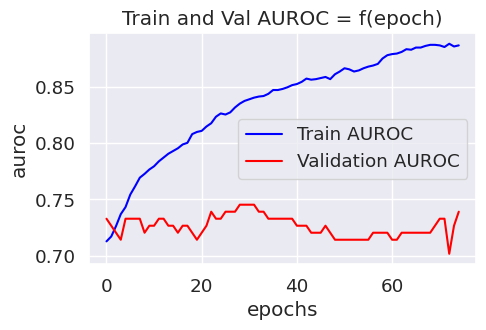

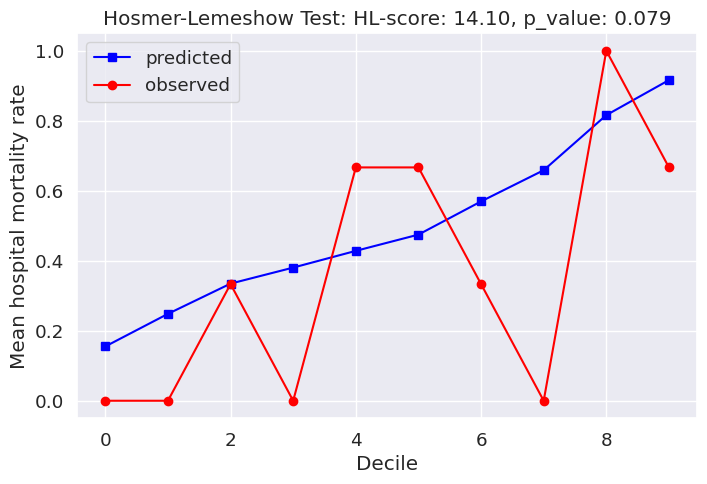

/tmp/ipykernel_13422/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)

 20%|██████████████████████████████████▏                                                                                                                                        | 1/5 [00:05<00:21,  5.26s/it]

test AUROC: 0.770
test Precision: 0.500
test Recall: 0.545
test Specificity: 0.600
test Accuracy: 0.633
test F1 Score: 0.522
test HL Score: 14.103
test Brier Score: 0.201
proportion deceased: 0.3548387096774194
Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel2                               [64, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [64, 120, 16]             704
│    └─LSTM: 2-2                         [64, 120, 16]             704
│    └─LSTM: 2-3                         [64, 120, 16]             704
│    └─LSTM: 2-4                         [64, 120, 16]             704
│    └─LSTM: 2-5                         [64, 120, 16]             704
│    └─LSTM: 2-6                         [64, 120, 16]             704
│    └─LSTM: 2-7                         [64, 120, 16]             704
│    └─LSTM: 2-8                         [64, 120, 16]             704
│    └

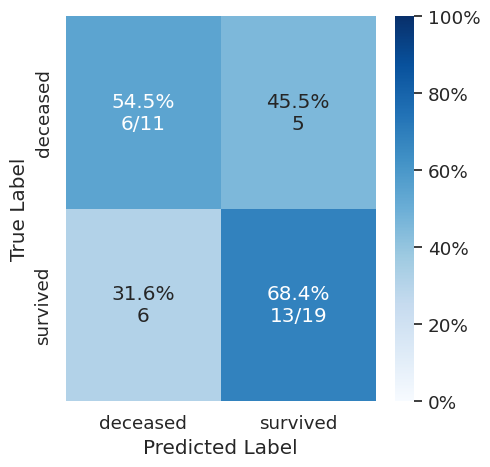

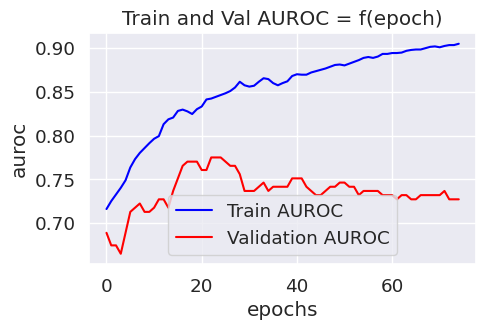

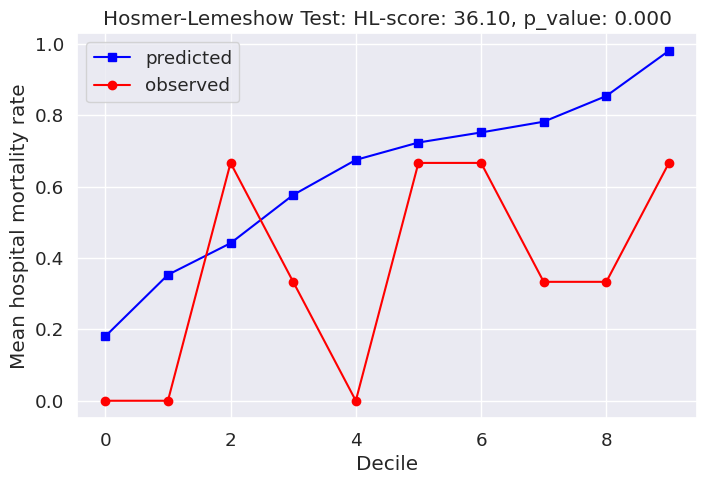

/tmp/ipykernel_13422/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)

 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 2/5 [00:10<00:15,  5.00s/it]

test AUROC: 0.679
test Precision: 0.455
test Recall: 0.909
test Specificity: 0.267
test Accuracy: 0.567
test F1 Score: 0.606
test HL Score: 36.102
test Brier Score: 0.280
proportion deceased: 0.3333333333333333
Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel2                               [64, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [64, 120, 16]             704
│    └─LSTM: 2-2                         [64, 120, 16]             704
│    └─LSTM: 2-3                         [64, 120, 16]             704
│    └─LSTM: 2-4                         [64, 120, 16]             704
│    └─LSTM: 2-5                         [64, 120, 16]             704
│    └─LSTM: 2-6                         [64, 120, 16]             704
│    └─LSTM: 2-7                         [64, 120, 16]             704
│    └─LSTM: 2-8                         [64, 120, 16]             704
│    └

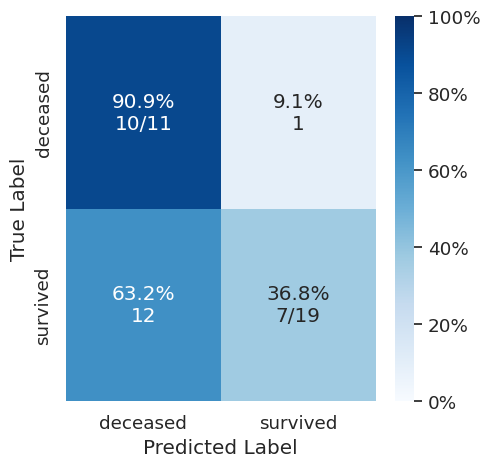

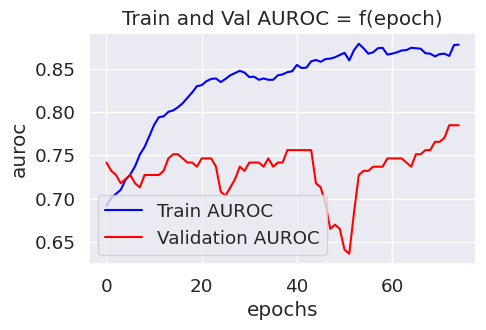

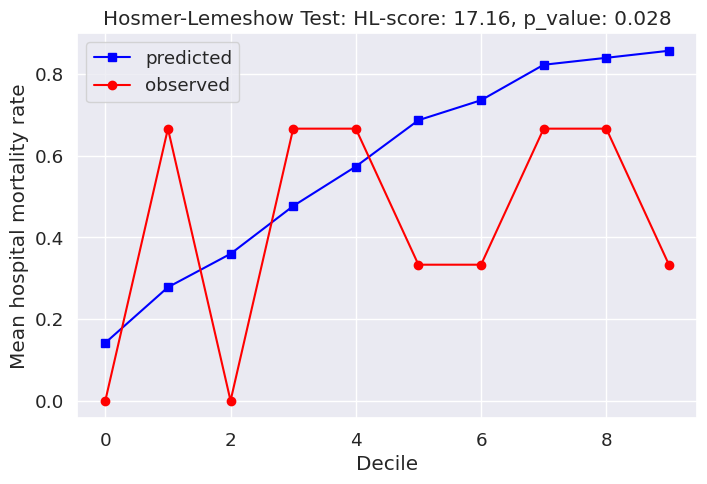

/tmp/ipykernel_13422/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 3/5 [00:14<00:09,  4.91s/it]

test AUROC: 0.602
test Precision: 0.474
test Recall: 0.692
test Specificity: 0.367
test Accuracy: 0.533
test F1 Score: 0.562
test HL Score: 17.163
test Brier Score: 0.273
proportion deceased: 0.3225806451612903
Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel2                               [64, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [64, 120, 16]             704
│    └─LSTM: 2-2                         [64, 120, 16]             704
│    └─LSTM: 2-3                         [64, 120, 16]             704
│    └─LSTM: 2-4                         [64, 120, 16]             704
│    └─LSTM: 2-5                         [64, 120, 16]             704
│    └─LSTM: 2-6                         [64, 120, 16]             704
│    └─LSTM: 2-7                         [64, 120, 16]             704
│    └─LSTM: 2-8                         [64, 120, 16]             704
│    └

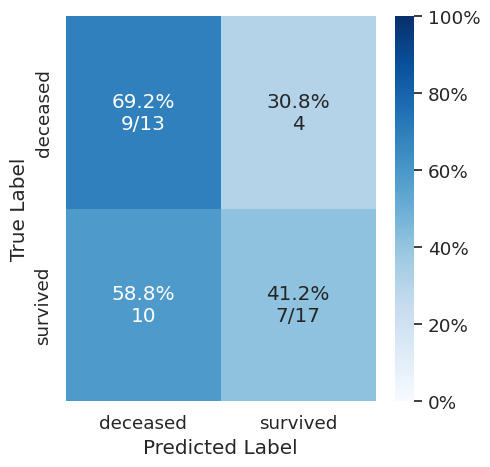

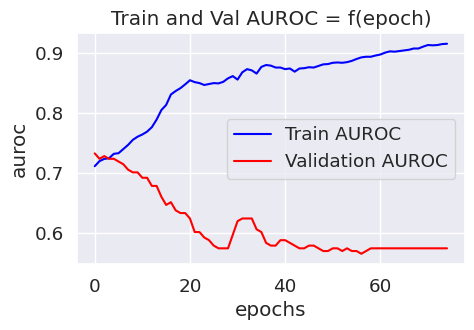

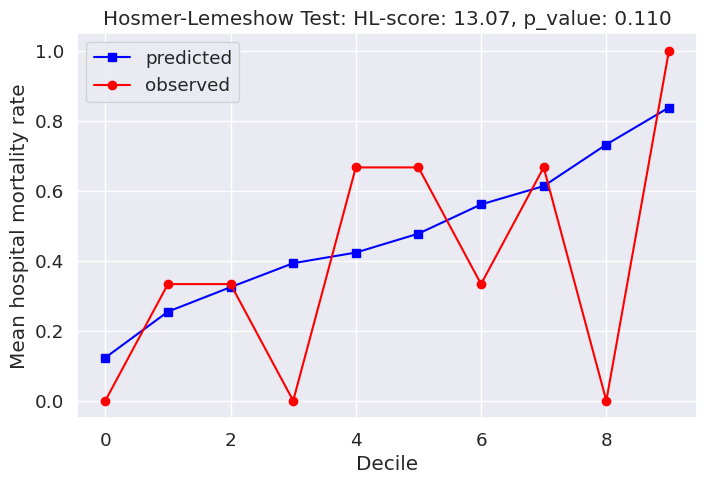

/tmp/ipykernel_13422/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 4/5 [00:19<00:04,  4.81s/it]

test AUROC: 0.699
test Precision: 0.500
test Recall: 0.500
test Specificity: 0.600
test Accuracy: 0.600
test F1 Score: 0.500
test HL Score: 13.067
test Brier Score: 0.221
proportion deceased: 0.3870967741935484
Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel2                               [64, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─LSTM: 2-1                         [64, 120, 16]             704
│    └─LSTM: 2-2                         [64, 120, 16]             704
│    └─LSTM: 2-3                         [64, 120, 16]             704
│    └─LSTM: 2-4                         [64, 120, 16]             704
│    └─LSTM: 2-5                         [64, 120, 16]             704
│    └─LSTM: 2-6                         [64, 120, 16]             704
│    └─LSTM: 2-7                         [64, 120, 16]             704
│    └─LSTM: 2-8                         [64, 120, 16]             704
│    └

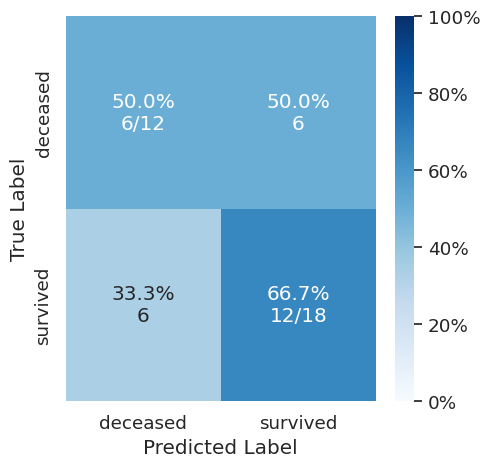

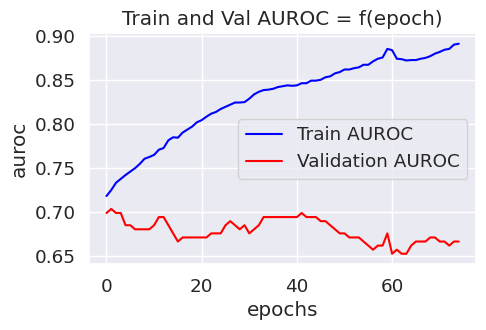

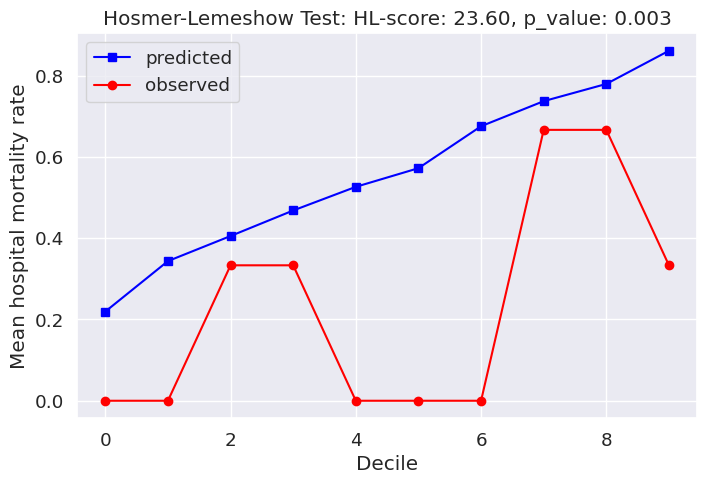

/tmp/ipykernel_13422/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.22s/it]

test AUROC: 0.733
test Precision: 0.263
test Recall: 0.714
test Specificity: 0.367
test Accuracy: 0.467
test F1 Score: 0.385
test HL Score: 23.602
test Brier Score: 0.270
Mean AUROC: 0.697
Mean Precision: 0.438
Mean Recall: 0.672
Mean Specificity: 0.440
Mean Accuracy: 0.560
Mean F1 Score: 0.515
Mean Brier Score: 0.270
SD Auroc: 0.057
Total Mean AUROC: 0.697 ± 0.057
Total Mean Precision: 0.438
Total Mean Recall: 0.672
Total Mean Specificity: 0.440
Total Mean Accuracy: 0.560
Total Mean F1 Score: 0.515
Total Mean Brier Score: 0.249


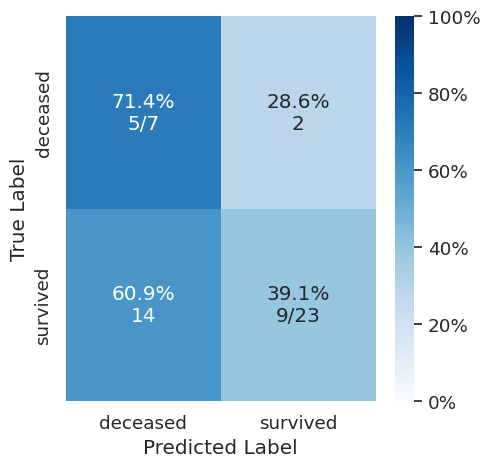

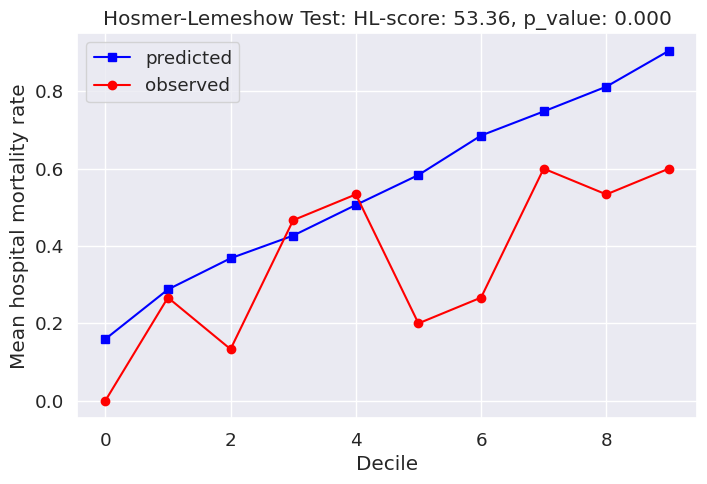

In [153]:
best_val_auroc_all_models = 0
best_model_state_dict = 0

aurocs_all = []
precisions_mean = []
recalls_mean = []
tnrs_mean = []
accuracies_mean = []
f1s_mean = []   
briers_mean = []

mean_fpr = np.linspace(0, 1, 100)
tprs = []
predictions_list = []
labels_list = []

# --> Décommenter les données qu'on veut utiliser

# train_data = train_data_Mimic
# train_target = train_target_Mimic
# test_data = test_data_Mimic
# test_target = test_target_Mimic

# train_data = train_data_Mimic_Imputed
# train_target = train_target_Mimic_Imputed
# test_data = test_data_Mimic_Imputed
# test_target = test_target_Mimic_Imputed


# train_data = train_data_Ventiles
# train_target = train_target_Ventiles
# test_data = test_data_Ventiles
# test_target = test_target_Ventiles

# train_data = train_data_Ventiles_Imputed
# train_target = train_target_Ventiles_Imputed
# test_data = test_data_Ventiles_Imputed
# test_target = test_target_Ventiles_Imputed


# train_data = np.concatenate((train_data_Mimic, test_data_Mimic))
# train_target = np.concatenate((train_target_Mimic, test_target_Mimic))
# test_data = data_ECMO
# test_target = target_ECMO

# train_data = np.concatenate((train_data_Ventiles, test_data_Ventiles))
# train_target = np.concatenate((train_target_Ventiles, test_target_Ventiles))
# test_data = data_ECMO
# test_target = target_ECMO


# train_data = np.concatenate((train_data_Mimic_Imputed, test_data_Mimic_Imputed))
# train_target = np.concatenate((train_target_Mimic_Imputed, test_target_Mimic_Imputed))
# test_data = data_ECMO_Imputed
# test_target = target_ECMO_Imputed

# train_data = np.concatenate((train_data_Ventiles_Imputed, test_data_Ventiles_Imputed))
# train_target = np.concatenate((train_target_Ventiles_Imputed, test_target_Ventiles_Imputed))
# test_data = data_ECMO_Imputed
# test_target = target_ECMO_Imputed


# train_data = train_data_ECMO
# train_target = train_target_ECMO
# test_data = test_data_ECMO
# test_target = test_target_ECMO

# train_data = train_data_ECMO_Imputed
# train_target = train_target_ECMO_Imputed
# test_data = test_data_ECMO_Imputed
# test_target = test_target_ECMO_Imputed


# train_data = data_ECMO
# train_target = target_ECMO
# test_data = []
# test_target = []

train_data = data_ECMO_Imputed
train_target = target_ECMO_Imputed
test_data = []
test_target = []


# 0 --> HR
# 1 --> SpO2
# 2 --> PAD
# 3 --> PAM
# 4 --> PAS
# 5 --> RR
# 6 --> Temperature
# 7 --> Diuresis
# 8 --> FiO2
# 9 --> Compliance 
# 10 --> Dialyse
# 11 --> Age
# 12 --> Sexe
# 13 --> IMC
# 14 --> IGS

# Scope uniquement
# idx_variables_kept = [0,1,2,3,4,5,6]

# + Données démographiques
# idx_variables_kept = [0,1,2,3,4,5,6,11,12,13,14]

# + Scope Etendu (+ FiO2 et Compliance)
# idx_variables_kept = [0,1,2,3,4,5,6,8,9,11,12,13,14]

# + Données DPI
idx_variables_kept = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

# train_data = train_data[:,:,idx_variables_kept]
# test_data = test_data[:,:,idx_variables_kept]

save_path = "saved_models/temp.pth"
load_path = None
load_path = "saved_models/temp0.pth"

K = 5
num_train = 1

for i in tqdm(range(num_train), total=num_train):
    
    aurocs = []
    precisions = []
    recalls = []
    tnrs = []
    accuracies = []
    f1s = []
    briers = []
    
    for j in tqdm(range(5)):
        auroc, precision, recall, tnr, f1, accuracy, HL_score, brier_score, best_val_auroc, state_dict, predictions, true_labels, best_threshold_acc, best_threshold_f1 = train_model(
                                                                                                                                    train_data = train_data,
                                                                                                                                    train_target = train_target,
                                                                                                                                    test_data = test_data,
                                                                                                                                    test_target = test_target,
                                                                                                                                    num_fold = K,
                                                                                                                                    validation_fold = j,
                                                                                                                                    validation_activated = True,
                                                                                                                                    test_activated = True,
                                                                                                                                    num_epochs = 75, 
                                                                                                                                    model_name = "LSTM2",
                                                                                                                                    verbose = True, 
                                                                                                                                    save_path = save_path, 
                                                                                                                                    save_model = True, 
                                                                                                                                    plot_train_curves = True,
                                                                                                                                    compute_HL = True,
                                                                                                                                    calibration_activated = False,
                                                                                                                                    augmentation_activated = False,
                                                                                                                                    load_model_path = load_path
                                                                                                                                    )
        
        aurocs.append(auroc)
        precisions.append(precision)
        recalls.append(recall)
        tnrs.append(tnr)
        f1s.append(f1)
        accuracies.append(accuracy)
        briers.append(brier_score)
        
        print(f"test AUROC: {auroc:.3f}")
        print(f"test Precision: {precision:.3f}")
        print(f"test Recall: {recall:.3f}")
        print(f"test Specificity: {tnr:.3f}")
        print(f"test Accuracy: {accuracy:.3f}")
        print(f"test F1 Score: {f1:.3f}")
        print(f"test HL Score: {HL_score:.3f}")
        print(f"test Brier Score: {brier_score:.3f}")
        
        fpr, tpr, _ = roc_curve(true_labels, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

        predictions_list = predictions_list + list(predictions)
        labels_list = labels_list + list(true_labels)
    
    print(f"Mean AUROC: {np.mean(aurocs):.3f}")
    print(f"Mean Precision: {np.mean(precisions):.3f}")
    print(f"Mean Recall: {np.mean(recalls):.3f}")
    print(f"Mean Specificity: {np.mean(tnrs):.3f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.3f}")
    print(f"Mean F1 Score: {np.mean(f1s):.3f}")
    print(f"Mean Brier Score: {np.mean(brier_score):.3f}")
    print(f"SD Auroc: {np.std(aurocs):.3f}")

    aurocs_all = aurocs_all + aurocs
    precisions_mean.append(np.mean(precisions))
    recalls_mean.append(np.mean(recalls))
    tnrs_mean.append(np.mean(tnrs))
    accuracies_mean.append(np.mean(accuracies))
    f1s_mean.append(np.mean(f1s))
    briers_mean.append(np.mean(briers))
    
# print(f"best val_auroc: {best_val_auroc_all_models:.4f}")
# print(f"num_algos: {np.size(aurocs)}")

print(f"Total Mean AUROC: {np.mean(aurocs_all):.3f} ± {np.std(aurocs_all):.3f}")
print(f"Total Mean Precision: {np.mean(precisions_mean):.3f}")
print(f"Total Mean Recall: {np.mean(recalls_mean):.3f}")
print(f"Total Mean Specificity: {np.mean(tnrs_mean):.3f}")
print(f"Total Mean Accuracy: {np.mean(accuracies_mean):.3f}")
print(f"Total Mean F1 Score: {np.mean(f1s_mean):.3f}")
print(f"Total Mean Brier Score: {np.mean(briers_mean):.3f}")



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1,1)

list_to_save = [aurocs_all, mean_tpr, predictions_list, labels_list]

saved_results_folder = "./saved_results_3/"
saved_file_name = "MLSTM_ECMO2"

# with open(saved_results_folder + saved_file_name + ".pkl", 'wb') as file:
#     pickle.dump(list_to_save, file)



deciles = np.percentile(predictions_list, np.arange(0, 101, 10))
decile_labels = pd.cut(predictions_list, bins=deciles, labels=False, include_lowest=True)

HL_num_groups = np.zeros(10)
HL_pred_groups = np.zeros(10)
HL_true_groups = np.zeros(10)

for k in range(len(predictions_list)):
    group = decile_labels[k]
    HL_num_groups[group] +=1
    HL_pred_groups[group] += predictions_list[k]
    if labels_list[k] > 0.5:
        HL_true_groups[group] += 1
        
HL_score = np.sum(np.square(HL_true_groups-HL_pred_groups)/(HL_pred_groups*(1-HL_pred_groups/HL_num_groups)))
HL_p_value = 1 - chi2.cdf(HL_score, df=8)

plt.figure(figsize=(8, 5))

plt.plot(np.linspace(0,9,10), HL_pred_groups/HL_num_groups, 's-', label='predicted', color='blue')
plt.plot(np.linspace(0,9,10), HL_true_groups/HL_num_groups, 'o-', label='observed', color='red')

plt.xlabel('Decile')
plt.ylabel('Mean hospital mortality rate')
plt.title(f'Hosmer-Lemeshow Test: HL-score: {HL_score:.2f}, p_value: {HL_p_value:.3f}')

plt.legend()

plt.show()

best threshold (acc) 0.9797979797979799
best threshold (f1) 0.7474747474747475


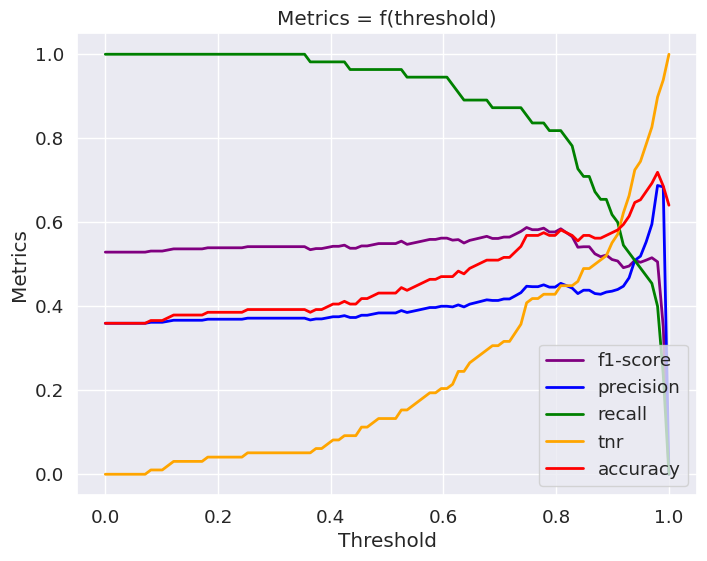

In [241]:
f1_scores = []
precisions = []
recalls = []
tnrs = []
accuracies = []

thresholds = np.linspace(0,1,100)

predictions = np.array(predictions)
true_labels = np.array(true_labels)

for threshold in thresholds:
    predictions_binary = (predictions > threshold).astype(int)
    
    f1 = f1_score(true_labels, predictions_binary, zero_division=0)
    accuracy = accuracy_score(true_labels, predictions_binary)
    precision = precision_score(true_labels, predictions_binary, zero_division=0)
    recall = recall_score(true_labels, predictions_binary, zero_division=0)
    tnr = tnr_score(true_labels, predictions_binary)
    
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    tnrs.append(tnr)
    accuracies.append(accuracy)
    
print(f"best threshold (acc) {thresholds[np.array(accuracies).argmax()]}")
print(f"best threshold (f1) {thresholds[np.array(f1_scores).argmax()]}")

plt.figure(figsize=(8, 6))

plt.plot(thresholds, f1_scores, lw=2, color='purple', label='f1-score')
plt.plot(thresholds, precisions, lw=2, color='blue', label='precision')
plt.plot(thresholds, recalls, lw=2, color='green', label='recall')
plt.plot(thresholds, tnrs, lw=2, color='orange', label='tnr')
plt.plot(thresholds, accuracies, lw=2, color='red', label='accuracy')

plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics = f(threshold)')
plt.legend()
plt.show()


best threshold: 0.808
With best_threshold_acc: ACCURACY=0.582, PRECISION=0.455, RECALL=0.818, F1-SCORE=0.584, TNR=0.4489795918367347


/tmp/ipykernel_317265/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


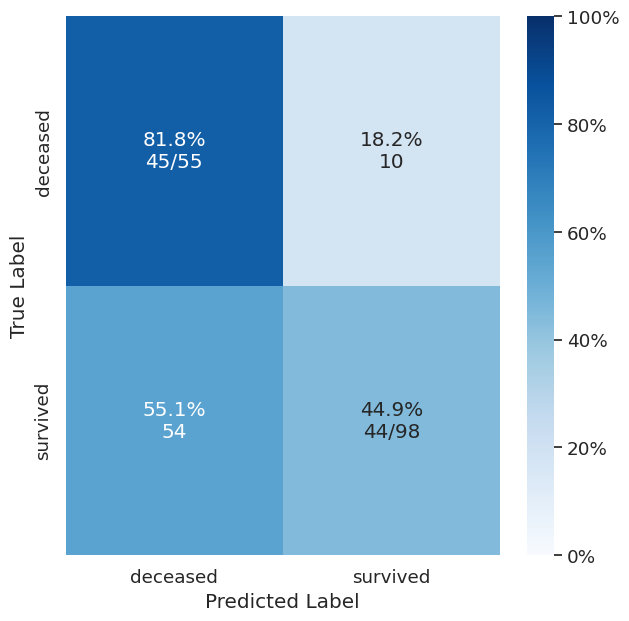

In [242]:
threshold = best_threshold_acc
# threshold = 0.1
predictions = np.array(predictions_list).ravel()
true_labels = np.array(labels_list)


predictions_binary = (predictions > threshold).astype(int)

f1 = f1_score(true_labels, predictions_binary, zero_division=0)
precision = precision_score(true_labels, predictions_binary, zero_division=0)
recall = recall_score(true_labels, predictions_binary, zero_division=0)
tnr = tnr_score(true_labels, predictions_binary)
accuracy = accuracy_score(true_labels, predictions_binary)

# plt.figure(figsize=(8, 6))

# plt.plot(thresholds, f1_scores, lw=2, color='purple', label='f1-score')
# plt.plot(thresholds, precisions, lw=2, color='blue', label='precision')
# plt.plot(thresholds, recalls, lw=2, color='green', label='recall')
# plt.plot(thresholds, tnrs, lw=2, color='orange', label='tnr')
# plt.plot(thresholds, accuracies, lw=2, color='red', label='accuracy')

# plt.xlabel('Threshold')
# plt.ylabel('Metrics')
# plt.title('F1-Score = f(threshold)')
# plt.legend()
# plt.show()

print(f"best threshold: {best_threshold_acc:.3f}")
print(f"With best_threshold_acc: ACCURACY={accuracy:.3f}, PRECISION={precision:.3f}, RECALL={recall:.3f}, F1-SCORE={f1:.3f}, TNR={tnr}")

cm_analysis(true_labels, predictions_binary, [1,0], ["deceased","survived"])

best threshold: 0.576
With best_threshold_f1: ACCURACY=0.464, PRECISION=0.397, RECALL=0.945, F1-SCORE=0.559, TNR=0.19387755102040816


/tmp/ipykernel_317265/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


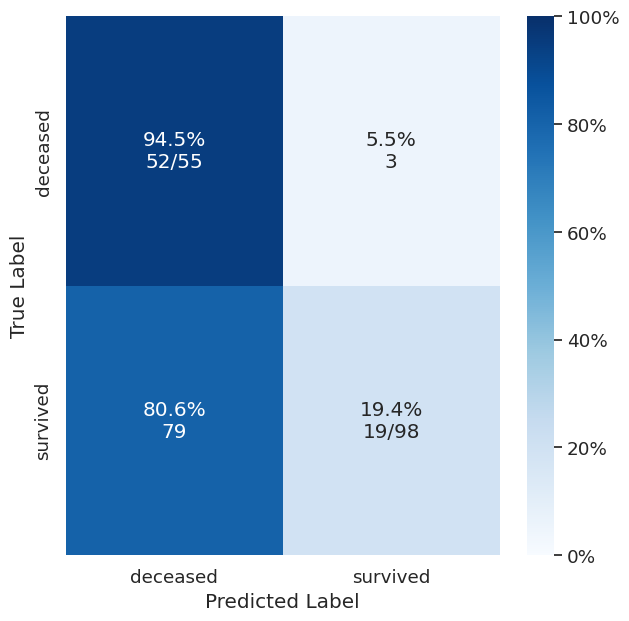

In [243]:
threshold = best_threshold_f1
# threshold = 0.1
predictions = np.array(predictions_list).ravel()
true_labels = np.array(labels_list)


predictions_binary = (predictions > threshold).astype(int)

f1 = f1_score(true_labels, predictions_binary, zero_division=0)
precision = precision_score(true_labels, predictions_binary, zero_division=0)
recall = recall_score(true_labels, predictions_binary, zero_division=0)
tnr = tnr_score(true_labels, predictions_binary)
accuracy = accuracy_score(true_labels, predictions_binary)

# plt.figure(figsize=(8, 6))

# plt.plot(thresholds, f1_scores, lw=2, color='purple', label='f1-score')
# plt.plot(thresholds, precisions, lw=2, color='blue', label='precision')
# plt.plot(thresholds, recalls, lw=2, color='green', label='recall')
# plt.plot(thresholds, tnrs, lw=2, color='orange', label='tnr')
# plt.plot(thresholds, accuracies, lw=2, color='red', label='accuracy')

# plt.xlabel('Threshold')
# plt.ylabel('Metrics')
# plt.title('F1-Score = f(threshold)')
# plt.legend()
# plt.show()

print(f"best threshold: {best_threshold_f1:.3f}")
print(f"With best_threshold_f1: ACCURACY={accuracy:.3f}, PRECISION={precision:.3f}, RECALL={recall:.3f}, F1-SCORE={f1:.3f}, TNR={tnr}")

cm_analysis(true_labels, predictions_binary, [1,0], ["deceased","survived"])

/tmp/ipykernel_31455/676519006.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


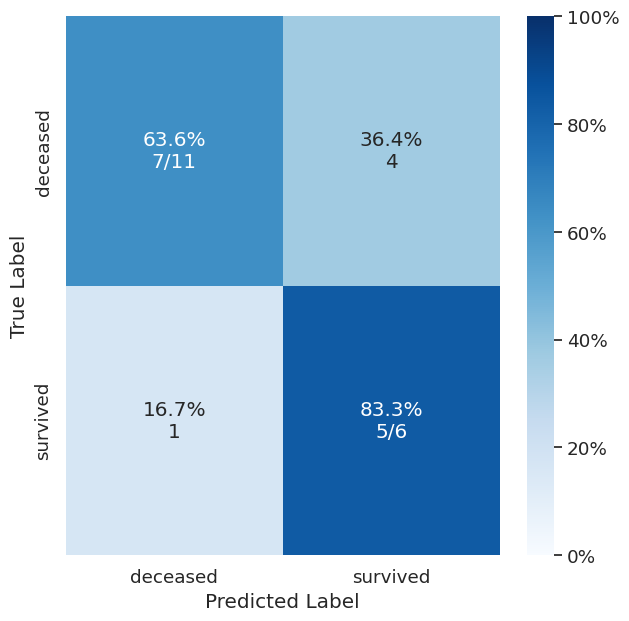

In [30]:
predictions_binary = predictions > best_threshold

cm_analysis(true_labels, predictions_binary, [1,0], ["deceased","survived"])